# Initialization

In [1]:
import pickle
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from utils import *



## parameters:

In [2]:

# parser = argparse.ArgumentParser()
# parser.add_argument('--reduceFeatures', type=int, default=1, choices=[0, 1],
#                     help='Set to 1 to reduce features, 0 to keep all features')
# parser.add_argument('--edgeSplit', type=int, default=0, choices=[0, 1],
#                     help='Set to 0 to split nodes, 1 to split edges')
# parser.add_argument('--independentTest', type=int, default=0, choices=[0, 1],
#                     help='Set to 1 to use independent test set (only for node split)')
# parser.add_argument('--nodeEmb', type=int, default=2, choices=[0, 1, 2, 3],
#                     help='Node embeddings: 0=reducedPT, 1=originalPT, 2=random, 3=gene expression')
# parser.add_argument('--gnnGraph', type=int, default=4, choices=[0, 1, 2, 3, 4],
#                     help='Graph type: 0=PT-dist, 1=Corr, 2=Dense, 3=Complete, 4=CellOracle')

reduceFeatures = 1
edgeSplit = 0
independentTest = 0
nodeEmb = 0
gnnGraph = 0


## load genePT embeddings

In [3]:
dataPath = "GenePT_emebdding_v2/GenePT_gene_embedding_ada_text.pickle"
# load data
with open(dataPath , "rb") as f:
    data_PT = pickle.load(f)

In [4]:
gene_names_all = list(data_PT.keys())

print("Number of all genes: ", len(gene_names_all))
# print 10 example names
print("First 10 gene names: ", gene_names_all[:10])
# Get the embedding for the first gene
gene_name_eg = 'AATK' # gene_names[0]
embedding = np.array(data_PT[gene_name_eg])
print("Gene name: ", gene_name_eg)
print("Embedding size: ", embedding.shape[0])


Number of all genes:  93800
First 10 gene names:  ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A2MP1', 'A3GALT2', 'A4GALT']
Gene name:  AATK
Embedding size:  1536


## Load gene experssion data

In [5]:
data_path_sample = 'Data/PBMC/PBMC-ALL_ExpressionData.csv'
L = 10000 # number of cells to load (use None to load all cells)
L = None
if L is not None:
    data_sample = pd.read_csv(data_path_sample, header=0, index_col=0, usecols=range(L + 1)).T
else:
    data_sample = pd.read_csv(data_path_sample, header=0, index_col=0).T
# data_sample = data_sample.transform(lambda x: np.log(x + 1))
print("Reading data completed!")
# get number of genes and cells
num_cells_sample, num_genes_sample = data_sample.shape
print(f"Number of cells: {num_cells_sample}, Number of genes: {num_genes_sample}")
# get the name of the genes in the dataset
gene_names_sample = list(data_sample.columns)
# print("Name of the genes present in the sample ", gene_names_sample)

# Function to get the present genes and their embeddings
# X_sample_PT: the gene embeddings from PT for the genes present in the sample
present_genes, X_sample_PT = get_present(gene_names_sample, gene_names_all, data_PT)
print(f"Number of present genes: {len(present_genes)}")


# get the expression of the present genes
present_expression = data_sample[present_genes].T.values
X_sample = np.array(present_expression)
print("X shape: ", X_sample.shape) # each row is the embedding of that gene

Reading data completed!
Number of cells: 100000, Number of genes: 1000
Present genes found and embeddings shape: (802, 1536)
Number of present genes: 802
X shape:  (802, 100000)


## load the ground truth GRN

In [6]:
# load the true GRN:
data_path_true = 'Data/PBMC/PBMC-ALL_Imposed_GRN.csv'
ref_grn = load_edge_set(data_path_true)
ref_grn = set((g1, g2) for g1, g2 in ref_grn if g1 in present_genes and g2 in present_genes)
N = len(present_genes)
A_true = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i != j:
            A_true[i,j] = 1 if (present_genes[i], present_genes[j]) in ref_grn else 0

## load the celloracle base GRN

In [7]:
# load the true GRN:
data_path_cell = 'Data/celloracle_baseGRN.csv'
cell_grn = load_edge_set(data_path_cell)
cell_grn = set((g1, g2) for g1, g2 in cell_grn if g1 in present_genes and g2 in present_genes)
N = len(present_genes)
A_celloracle = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i != j:
            A_celloracle[i,j] = 1 if (present_genes[i], present_genes[j]) in cell_grn else 0

print("Number of edges in the celloracle adjacency matrix: ", np.sum(A_celloracle))

Number of edges in the celloracle adjacency matrix:  6499.0


# Feature selection

In [8]:
X_sample_NB = np.zeros((X_sample.shape[0], 7))  # Initialize an array for the features
for i in range(X_sample.shape[0]):
    if i % 100 == 0:
        print(f"Processing gene {i+1}/{X_sample.shape[0]}")
    X_sample_NB[i, :] = fit_nb_and_extract_features(X_sample[i, :])

# Map X_sample_PT to X_sample to find the important features and do dimension reduction:
if reduceFeatures:
    print("Mapping PT features with shape:", X_sample_PT.shape , " to sample features with shape:", X_sample.shape)
    LM = Ridge(alpha=1.0)
    LM.fit(X_sample_PT, X_sample) # change to X_sample_NB if using NB features
    selector = SelectFromModel(LM, prefit=True, threshold='mean')
    X_reduced_PT = selector.transform(X_sample_PT)
    print("After model fitting: ", X_reduced_PT.shape)
    scaler = StandardScaler()
    X_reduced_PT = scaler.fit_transform(X_reduced_PT)
    pca = PCA(n_components=50, random_state=42, whiten=False)
    X_reduced_PT = pca.fit_transform(X_reduced_PT)

    print("Reduced feature shape: ", X_reduced_PT.shape)
else:
    X_reduced_PT = X_sample_PT
    print("Using original PT features with shape: ", X_reduced_PT.shape)

Processing gene 1/802
Processing gene 101/802
Processing gene 201/802
Processing gene 301/802
Processing gene 401/802
Processing gene 501/802
Processing gene 601/802
Processing gene 701/802
Processing gene 801/802
Mapping PT features with shape: (802, 1536)  to sample features with shape: (802, 100000)
After model fitting:  (802, 611)
Reduced feature shape:  (802, 50)


## Form edge features

In [9]:
# Get upper triangle indices (excluding diagonal)
triu_indices = np.triu_indices(N, k=1)

# Prepare edge features and labels
edge_features_PT = []
edge_features_reduced = []
edge_labels = []
edge_pairs = []

for i, j in zip(*triu_indices):
    if j < i:
        continue

    edge_pairs.append((i, j))
    label = A_true[i, j]
    edge_labels.append(label)
    # Feature: average or concatenate of the two nodes' features
    feat_i = X_reduced_PT[i]
    feat_j = X_reduced_PT[j]
    # edge_feat = np.concatenate([feat_i, feat_j])
    edge_feat = (feat_i + feat_j) / 2 
    edge_features_reduced.append(edge_feat)

    feat_i = X_sample_PT[i]
    feat_j = X_sample_PT[j]
    # edge_feat_PT = np.concatenate([feat_i, feat_j])
    edge_feat_PT = (feat_i + feat_j) / 2 
    edge_features_PT.append(edge_feat_PT)
    
    

edge_features_PT = np.array(edge_features_PT)
edge_features_reduced = np.array(edge_features_reduced)
edge_labels = np.array(edge_labels)

## All data evaluation

In [10]:
# LR on whole data with no splitting:

# Whole features:
clf = LogisticRegression(max_iter=1000)
clf.fit(edge_features_PT, edge_labels)
# Evaluation
y_pred_prob = clf.predict_proba(edge_features_PT)[:, 1]
y_pred = clf.predict(edge_features_PT)

print("Using whole PT featuresto predict the true edges.")
print("Edge features shape:", edge_features_PT.shape)
print("Accuracy:", accuracy_score(edge_labels, y_pred))
print("ROC AUC:", roc_auc_score(edge_labels, y_pred_prob))
print("Confusion matrix:\n", confusion_matrix(edge_labels, y_pred), "F1 Score: ", np.round(100*f1_score(edge_labels, y_pred),2))

# Reduced features:
clf_reduced = LogisticRegression(max_iter=1000)
clf_reduced.fit(edge_features_reduced, edge_labels)
# Evaluation
y_pred_prob_reduced = clf_reduced.predict_proba(edge_features_reduced)[:, 1]
y_pred_reduced = clf_reduced.predict(edge_features_reduced)

print("Using reduced PT features to predict the true edges.")
print("Edge features shape:", edge_features_reduced.shape)
print("Accuracy:", accuracy_score(edge_labels, y_pred_reduced))
print("ROC AUC:", roc_auc_score(edge_labels, y_pred_prob_reduced))
print("Confusion matrix:\n", confusion_matrix(edge_labels, y_pred_reduced), "F1 Score: ", np.round(100*f1_score(edge_labels, y_pred_reduced),2))

Using whole PT featuresto predict the true edges.
Edge features shape: (321201, 1536)
Accuracy: 0.9673444354158299
ROC AUC: 0.969489030754991
Confusion matrix:
 [[308421   1695]
 [  8794   2291]] F1 Score:  30.4
Using reduced PT features to predict the true edges.
Edge features shape: (321201, 50)
Accuracy: 0.9630044738341412
ROC AUC: 0.907078581179334
Confusion matrix:
 [[308702   1414]
 [ 10469    616]] F1 Score:  9.39


## PT-distance and correlation graphs

Edge density in PT adjacency matrix:  0.48082976080398254
Edge density in correlation matrix:  0.23275456801193023
Number of edges in PT adjacency matrix:  154443.0
Number of edges in correlation matrix:  74761.0
Number of shared edges:  39011.0


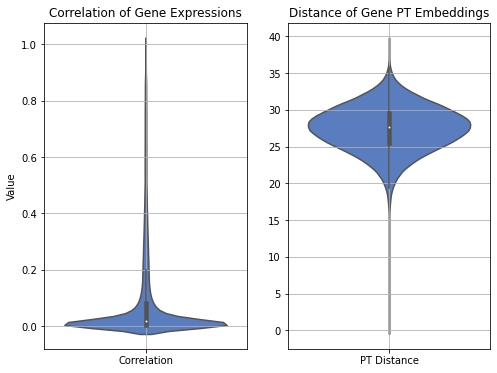

In [11]:
# Compute the PT distance matrix
D_PT = np.linalg.norm(X_reduced_PT[:, np.newaxis] - X_reduced_PT, axis=2, ord=2)
# cosine_sim_matrix = cosine_similarity(X_reduced_PT)
# D_PT = 1 - cosine_sim_matrix
np.fill_diagonal(D_PT, 0)
D_PT[D_PT < 0] = 0

Corr_matrix = wgcna_grn(X_sample, beta=1)
# Corr_matrix = cosine_similarity(X_sample)
Corr_dist = 1 - Corr_matrix


# Get the binary adjacency matrix from the correlation distance matrix
A_corr = get_adjacency_matrix(Corr_dist, threshold=None)
A_PT = get_adjacency_matrix(D_PT, threshold=None)

A_full = np.ones(np.shape(A_true))
np.fill_diagonal(A_full, 0)

A_dense = np.random.rand(np.shape(A_true)[0], np.shape(A_true)[1])
A_dense = (A_dense < 0.8).astype(int)
np.fill_diagonal(A_dense, 0)
i_upper = np.triu_indices_from(A_dense, k=1)
A_dense[i_upper[1], i_upper[0]] = A_dense[i_upper]

# compare Adjacency matrix with correlation matrix numerically
NN2 = (N * (N - 1) / 2)
A_PT_flat = A_PT.flatten()
A_corr_flat = A_corr.flatten()
num_edges_PT = np.sum(A_PT_flat > 0) / 2
num_edges_corr = np.sum(A_corr_flat > 0) / 2
print("Edge density in PT adjacency matrix: ", num_edges_PT / NN2)
print("Edge density in correlation matrix: ", num_edges_corr / NN2)
shared_edges = np.sum((A_PT_flat > 0) & (A_corr_flat > 0)) / 2
print("Number of edges in PT adjacency matrix: ", num_edges_PT)
print("Number of edges in correlation matrix: ", num_edges_corr)
print("Number of shared edges: ", shared_edges)


# get the violin plot for the distance and correlation
corr_values = Corr_matrix[np.triu_indices(N, k=1)]
dist_values = D_PT[np.triu_indices(N, k=1)]

plt.figure(figsize=(8, 6), facecolor='white')
plt.subplot(1, 2, 1)
sns.violinplot(data=[corr_values], palette='muted')
plt.xticks([0], ['Correlation'])
plt.ylabel('Value')
plt.grid()
plt.title('Correlation of Gene Expressions')
plt.subplot(1, 2, 2)
sns.violinplot(data=[dist_values], palette='muted')
plt.xticks([0], ['PT Distance'])
plt.grid()
plt.title('Distance of Gene PT Embeddings')
plt.show()


# save correlation matrix
i_corr, j_corr = np.triu_indices_from(A_corr, k=1)
nonzero_mask_corr = A_corr[i_corr, j_corr] != 0
i_corr = i_corr[nonzero_mask_corr]
j_corr = j_corr[nonzero_mask_corr]
edges_corr = [(present_genes[src], present_genes[tgt]) for src, tgt in zip(i_corr, j_corr)]
edges_corr_df = pd.DataFrame(edges_corr, columns=['Gene1', 'Gene2'])
edges_corr_df.to_csv('Data/PBMC/Corr_edges.csv', index=False)

# save PT matrix
i_PT, j_PT = np.triu_indices_from(A_PT, k=1)
nonzero_mask_PT = A_PT[i_PT, j_PT] != 0
i_PT = i_PT[nonzero_mask_PT]
j_PT = j_PT[nonzero_mask_PT]
edges_PT = [(present_genes[src], present_genes[tgt]) for src, tgt in zip(i_PT, j_PT)]
edges_PT_df = pd.DataFrame(edges_PT, columns=['Gene1', 'Gene2'])
edges_PT_df.to_csv('Data/PBMC/PT_edges.csv', index=False)

# Supervised learning

## Train/Test split

In [12]:
# splitting the data to train/test :
print(edge_features_PT.shape, edge_features_reduced.shape, edge_labels.shape, len(edge_pairs))

if edgeSplit:
    X_train_PT, X_test_PT, X_train_reduced, X_test_reduced, y_train, y_test, train_pairs, test_pairs = train_test_split(edge_features_PT, 
                                                                                                                        edge_features_reduced, edge_labels, 
                                                                                                                        edge_pairs, test_size=0.5, random_state=42)
else:
    all_nodes = np.arange(N)
    train_nodes, test_nodes = train_test_split(all_nodes, test_size=0.3, random_state=42, shuffle=True)
    train_node_set = set(train_nodes)
    test_node_set = set(test_nodes)
    print(train_node_set)

    train_idx = []
    test_idx = []
    train_pairs = []
    test_pairs = []
    idx = 0
    for (i,j) in edge_pairs:
        if i in train_node_set and j in train_node_set:
            train_idx.append(idx)
            train_pairs.append((i, j))
        else:
            if independentTest:
                if i in test_node_set and j in test_node_set: # this is for the case that test is completly unrelated to train
                    test_idx.append(idx)
                    test_pairs.append((i, j))
            else:
                test_idx.append(idx)
                test_pairs.append((i, j))
        idx += 1

    print("Number of training edges: ", len(train_idx))
    print("Number of testing edges: ", len(test_idx))


    X_train_PT = edge_features_PT[train_idx]
    X_test_PT = edge_features_PT[test_idx]

    X_train_reduced = edge_features_reduced[train_idx]
    X_test_reduced = edge_features_reduced[test_idx]

    y_train = edge_labels[train_idx]
    y_test = edge_labels[test_idx]

(321201, 1536) (321201, 50) (321201,) 321201
{0, 1, 3, 4, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 50, 51, 52, 53, 56, 57, 58, 59, 61, 62, 64, 68, 71, 74, 75, 80, 83, 85, 87, 88, 89, 91, 92, 93, 94, 95, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 114, 115, 116, 117, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 134, 138, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 156, 157, 159, 160, 161, 162, 163, 166, 167, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 194, 195, 197, 200, 201, 202, 203, 205, 206, 207, 214, 216, 217, 219, 221, 222, 223, 224, 225, 226, 228, 229, 230, 232, 233, 236, 237, 238, 240, 241, 242, 243, 245, 246, 248, 249, 251, 252, 253, 255, 256, 257, 258, 260, 261, 262, 263, 267, 268, 269, 270, 271, 272, 273, 274, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 2

## Simple ML models on split data

In [13]:
# RF on train/test split:
# Random forest:
clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf.fit(X_train_PT, y_train)
y_pred_prob_PT = clf.predict_proba(X_test_PT)[:, 1]
y_pred_PT = clf.predict(X_test_PT)

print("Random Forest:")
print("Using whole PT features")
print("Edge features shape:", edge_features_PT.shape)
print("Accuracy:", accuracy_score(y_test, y_pred_PT))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob_PT))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_PT), "F1 Score: ", np.round(100*f1_score(y_test, y_pred_PT),2))
if reduceFeatures:
    # Reduced features:
    clf_reduced = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    clf_reduced.fit(X_train_reduced, y_train)
    y_pred_prob_reduced = clf_reduced.predict_proba(X_test_reduced)[:, 1]
    y_pred_reduced = clf_reduced.predict(X_test_reduced)

    print("Using reduced PT features")
    print("Edge features shape:", edge_features_reduced.shape)
    print("Accuracy:", accuracy_score(y_test, y_pred_reduced))
    print("ROC AUC:", roc_auc_score(y_test, y_pred_prob_reduced))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_reduced), "F1 Score: ", np.round(100*f1_score(y_test, y_pred_reduced),2))

# LR on train/test split:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_PT, y_train)
y_pred_prob_PT = clf.predict_proba(X_test_PT)[:, 1]
y_pred_PT = clf.predict(X_test_PT)

print(100*"-")
print("Using whole PT features concatenation to predict the true edges.")
print("Edge features shape:", edge_features_PT.shape)
print("Accuracy:", accuracy_score(y_test, y_pred_PT))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob_PT))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_PT), "F1 Score: ", np.round(100*f1_score(y_test, y_pred_PT),2))

if reduceFeatures:
    # Reduced features:
    clf_reduced = LogisticRegression(max_iter=1000)
    clf_reduced.fit(X_train_reduced, y_train)
    y_pred_prob_reduced = clf_reduced.predict_proba(X_test_reduced)[:, 1]
    y_pred_reduced = clf_reduced.predict(X_test_reduced)

    print("Using reduced PT features concatenation to predict the true edges.")
    print("Edge features shape:", edge_features_reduced.shape)
    print("Accuracy:", accuracy_score(y_test, y_pred_reduced))
    print("ROC AUC:", roc_auc_score(y_test, y_pred_prob_reduced))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_reduced), "F1 Score: ", np.round(100*f1_score(y_test, y_pred_reduced),2))


Random Forest:
Using whole PT features
Edge features shape: (321201, 1536)
Accuracy: 0.9738668421469525
ROC AUC: 0.8727461212134086
Confusion matrix:
 [[159487    124]
 [  4165    345]] F1 Score:  13.86
Using reduced PT features
Edge features shape: (321201, 50)
Accuracy: 0.9730016268484838
ROC AUC: 0.8588291883866598
Confusion matrix:
 [[159536     75]
 [  4356    154]] F1 Score:  6.5
----------------------------------------------------------------------------------------------------
Using whole PT features concatenation to predict the true edges.
Edge features shape: (321201, 1536)
Accuracy: 0.9730259991104124
ROC AUC: 0.9076461062254725
Confusion matrix:
 [[159023    588]
 [  3839    671]] F1 Score:  23.26
Using reduced PT features concatenation to predict the true edges.
Edge features shape: (321201, 50)
Accuracy: 0.9690228550886236
ROC AUC: 0.8736931881823937
Confusion matrix:
 [[158745    866]
 [  4218    292]] F1 Score:  10.3


## Prepare GNN data

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert numpy adjacency matrix to sparse format
A_true_sparse = sp.csr_matrix(A_true)
edge_index_true, _ = from_scipy_sparse_matrix(A_true_sparse)

A_PT_sparse = sp.csr_matrix(A_PT)
edge_index_PT, _ = from_scipy_sparse_matrix(A_PT_sparse)

A_corr_sparse = sp.csr_matrix(A_corr)
edge_index_corr, _ = from_scipy_sparse_matrix(A_corr_sparse)

A_cell_sparse = sp.csr_matrix(A_celloracle)
edge_index_celloracle, _ = from_scipy_sparse_matrix(A_cell_sparse)

A_full_sparse = sp.csr_matrix(A_full)
edge_index_full, _ = from_scipy_sparse_matrix(A_full_sparse)

A_dense_sparse = sp.csr_matrix(A_dense)
edge_index_dense, _ = from_scipy_sparse_matrix(A_dense_sparse)

num_nodes = A_PT.shape[0]

# Choose the initial embeddings:
if nodeEmb==0:
    x = torch.Tensor(X_reduced_PT) # genePT embeddings
elif nodeEmb==1:
    x = torch.Tensor(X_sample_PT) # original PT embeddings
elif nodeEmb==2:
    x = torch.randn((num_nodes, 32)) # random guassian features
elif nodeEmb==3:
    x = torch.Tensor(X_sample_NB) # gene expression features

# Create PyG data object
if gnnGraph==0:
    edge_index_gnn = edge_index_PT
elif gnnGraph==1:
    edge_index_gnn = edge_index_corr
elif gnnGraph==2:
    edge_index_gnn = edge_index_dense
elif gnnGraph==3:
    edge_index_gnn = edge_index_full
elif gnnGraph==4:
    edge_index_gnn = edge_index_celloracle

data = Data(x=x, edge_index=edge_index_gnn).to(device) # PT dhould be used


# Convert back to torch tensors for mask use
train_mask = (torch.tensor([i for i, j in train_pairs]), torch.tensor([j for i, j in train_pairs]))
test_mask = (torch.tensor([i for i, j in test_pairs]), torch.tensor([j for i, j in test_pairs]))

## Train the model

In [15]:
adj_target = torch.FloatTensor(A_true).to(device)
model = GraphAutoEncoder(in_channels=data.x.shape[1], hidden_channels_list=[256], out_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
loss_min = 10e9
epoch_min = 0
for epoch in range(0, 5001):
    optimizer.zero_grad()
    adj_pred = model(data.x, data.edge_index)
    loss = adj_bce_loss(adj_pred, adj_target, mask=train_mask) # None: loss is calculated on the whole upper triangle of the adjacency matrix
    if loss.item() < loss_min:
        loss_min = loss.item()
        epoch_min = epoch
        with torch.no_grad():
            torch.save(model.state_dict(), 'Data/PBMC/model.pt')
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Best Loss: {loss_min:.4f}, Best Epoch: {epoch_min}")


Epoch 0, Loss: 0.6898, Best Loss: 0.6898, Best Epoch: 0


Epoch 500, Loss: 0.0766, Best Loss: 0.0766, Best Epoch: 500
Epoch 1000, Loss: 0.0660, Best Loss: 0.0660, Best Epoch: 998
Epoch 1500, Loss: 0.0679, Best Loss: 0.0646, Best Epoch: 1494
Epoch 2000, Loss: 0.0643, Best Loss: 0.0636, Best Epoch: 1982
Epoch 2500, Loss: 0.0636, Best Loss: 0.0627, Best Epoch: 2495
Epoch 3000, Loss: 0.0618, Best Loss: 0.0615, Best Epoch: 2989
Epoch 3500, Loss: 0.0605, Best Loss: 0.0603, Best Epoch: 3489
Epoch 4000, Loss: 4.1858, Best Loss: 0.0593, Best Epoch: 3939
Epoch 4500, Loss: 4.1858, Best Loss: 0.0593, Best Epoch: 3939
Epoch 5000, Loss: 4.1858, Best Loss: 0.0593, Best Epoch: 3939


## Evaluate the test set:

Best threshold (ROC): 0.00
Best threshold (PR): 0.33


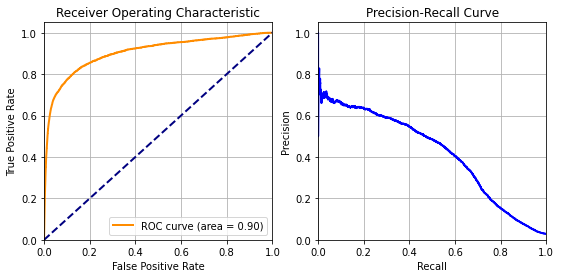

ROC AUC: 90.43
Precision: 54.01, Recall: 40.91, F1: 46.56
Confusion Matrix:
[[158040   1571]
 [  2665   1845]]


In [16]:
# load the saved model
model.load_state_dict(torch.load('Data/PBMC/model.pt'))
model.eval()
with torch.no_grad():
    adj_pred_eval = model(data.x, data.edge_index) 

# Remove self-loops (diagonal)
adj_pred_eval = adj_pred_eval * (1 - torch.eye(adj_pred_eval.size(0)).to(adj_pred_eval.device))

# Make the prediction symmetric:
N = adj_pred_eval.shape[0]
triu_indices = torch.triu_indices(N, N, offset=1)
adj_pred_eval[triu_indices[1], triu_indices[0]] = adj_pred_eval[triu_indices[0], triu_indices[1]]


adj_true_flat = adj_target[test_mask]
adj_pred_flat = adj_pred_eval[test_mask]


# plot the ROC curve
fpr, tpr, thresholds_pred = roc_curve(adj_true_flat.cpu().numpy(), adj_pred_flat.cpu().numpy())
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(9, 4), facecolor='white')
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# get the best threshold from the fpr, tpr, thresholds_pred
best_threshold_roc = thresholds_pred[np.argmax(tpr - fpr)]
print(f"Best threshold (ROC): {best_threshold_roc:.2f}")


# plot the recall-precision curve
precision, recall, thresholds_pred = precision_recall_curve(adj_true_flat.cpu().numpy(), adj_pred_flat.cpu().numpy())
plt.subplot(1,2,2)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
# get the best threshold from the precision, recall, thresholds_pred
# best_threshold_pr = thresholds_pred[np.argmax(precision + recall)]
best_threshold_pr = thresholds_pred[np.argmax(2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8))]

print(f"Best threshold (PR): {best_threshold_pr:.2f}")

plt.show()


# Threshold to get binary adjacency
# threshold = best_threshold_pr if best_threshold_pr > 0.1 else 0.50 
threshold = 0.50
adj_pred_eval_binary = (adj_pred_eval > threshold).float()
adj_pred_binary_flat = adj_pred_eval_binary[test_mask]
infered_grn = adj_pred_eval_binary

# Compute metrics
roc_auc = roc_auc_score(adj_true_flat.cpu().numpy(), adj_pred_flat.cpu().numpy())
f1 = f1_score(adj_true_flat.cpu().numpy(), adj_pred_binary_flat.cpu().numpy())
precision = precision_score(adj_true_flat.cpu().numpy(), adj_pred_binary_flat.cpu().numpy())
recall = recall_score(adj_true_flat.cpu().numpy(), adj_pred_binary_flat.cpu().numpy())
confusion = confusion_matrix(adj_true_flat.cpu().numpy(), adj_pred_binary_flat.cpu().numpy())

# Print results13.32
print(f"ROC AUC: {roc_auc*100:.2f}")
print(f"Precision: {precision*100:.2f}, Recall: {recall*100:.2f}, F1: {f1*100:.2f}")
print("Confusion Matrix:")
print(confusion)

# Unsupervised learning

## Prepare the GNN data:

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert numpy adjacency matrix to sparse format
A_true_sparse = sp.csr_matrix(A_true)
edge_index_true, _ = from_scipy_sparse_matrix(A_true_sparse)

A_PT_sparse = sp.csr_matrix(A_PT)
edge_index_PT, _ = from_scipy_sparse_matrix(A_PT_sparse)

A_corr_sparse = sp.csr_matrix(A_corr)
edge_index_corr, _ = from_scipy_sparse_matrix(A_corr_sparse)

A_cell_sparse = sp.csr_matrix(A_celloracle)
edge_index_celloracle, _ = from_scipy_sparse_matrix(A_cell_sparse)

A_full_sparse = sp.csr_matrix(A_full)
edge_index_full, _ = from_scipy_sparse_matrix(A_full_sparse)

A_dense_sparse = sp.csr_matrix(A_dense)
edge_index_dense, _ = from_scipy_sparse_matrix(A_dense_sparse)

num_nodes = A_PT.shape[0]

# Choose the initial embeddings:
if nodeEmb==0:
    x = torch.Tensor(X_reduced_PT) # genePT embeddings
elif nodeEmb==1:
    x = torch.Tensor(X_sample_PT) # original PT embeddings
elif nodeEmb==2:
    x = torch.randn((num_nodes, 32)) # random guassian features
elif nodeEmb==3:
    x = torch.Tensor(X_sample_NB) # gene expression features

# Create PyG data object
if gnnGraph==0:
    edge_index_gnn = edge_index_PT
elif gnnGraph==1:
    edge_index_gnn = edge_index_corr
elif gnnGraph==2:
    edge_index_gnn = edge_index_dense
elif gnnGraph==3:
    edge_index_gnn = edge_index_full
elif gnnGraph==4:
    edge_index_gnn = edge_index_celloracle

data = Data(x=x, edge_index=edge_index_gnn).to(device) # PT dhould be used

## Train the model

In [18]:
adj_target = torch.FloatTensor(A_celloracle).to(device)
model = GraphAutoEncoder(in_channels=data.x.shape[1], hidden_channels_list=[256], out_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
loss_min = 10e9
epoch_min = 0
for epoch in range(0, 1001):
    optimizer.zero_grad()
    adj_pred = model(data.x, data.edge_index)
    loss = adj_bce_loss(adj_pred, adj_target, mask=None, pos_weight=10) 
    if loss.item() < loss_min:
        loss_min = loss.item()
        epoch_min = epoch
        with torch.no_grad():
            torch.save(model.state_dict(), 'Data/PBMC/model.pt')
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Best Loss: {loss_min:.4f}, Best Epoch: {epoch_min}")


Epoch 0, Loss: 0.7515, Best Loss: 0.7515, Best Epoch: 0
Epoch 500, Loss: 0.1624, Best Loss: 0.1623, Best Epoch: 499


Epoch 1000, Loss: 0.1733, Best Loss: 0.1462, Best Epoch: 995


## Evaluate the model

Best threshold (ROC): 0.17
Best threshold (PR): 0.72


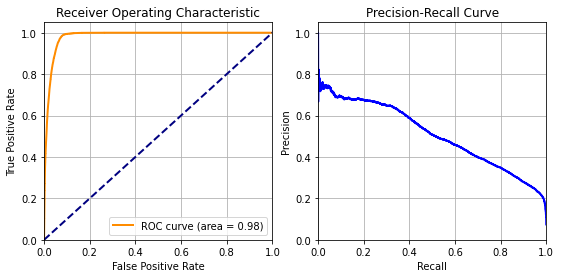

ROC AUC: 98.22
Precision: 28.45, Recall: 89.29, F1: 43.15
Confusion Matrix:
[[300105  14597]
 [   696   5803]]


In [19]:
# load the saved model
model.load_state_dict(torch.load('Data/PBMC/model.pt'))
model.eval()
with torch.no_grad():
    adj_pred_eval = model(data.x, data.edge_index) 

# Remove self-loops (diagonal)
adj_pred_eval = adj_pred_eval * (1 - torch.eye(adj_pred_eval.size(0)).to(adj_pred_eval.device))

# Make the prediction symmetric:
N = adj_pred_eval.shape[0]
triu_indices = torch.triu_indices(N, N, offset=1)
adj_pred_eval[triu_indices[1], triu_indices[0]] = adj_pred_eval[triu_indices[0], triu_indices[1]]


# Flatten only the upper triangle or the test mask:
adj_true_flat = adj_target[triu_indices[0], triu_indices[1]]
adj_pred_flat = adj_pred_eval[triu_indices[0], triu_indices[1]]


# plot the ROC curve
fpr, tpr, thresholds_pred = roc_curve(adj_true_flat.cpu().numpy(), adj_pred_flat.cpu().numpy())
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(9, 4), facecolor='white')
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# get the best threshold from the fpr, tpr, thresholds_pred
best_threshold_roc = thresholds_pred[np.argmax(tpr - fpr)]
print(f"Best threshold (ROC): {best_threshold_roc:.2f}")


# plot the recall-precision curve
precision, recall, thresholds_pred = precision_recall_curve(adj_true_flat.cpu().numpy(), adj_pred_flat.cpu().numpy())
plt.subplot(1,2,2)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
# get the best threshold from the precision, recall, thresholds_pred
# best_threshold_pr = thresholds_pred[np.argmax(precision + recall)]
best_threshold_pr = thresholds_pred[np.argmax(2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8))]

print(f"Best threshold (PR): {best_threshold_pr:.2f}")

plt.show()


# Threshold to get binary adjacency
# threshold = best_threshold_pr if best_threshold_pr > 0.1 else 0.50 
threshold = 0.50
adj_pred_eval_binary = (adj_pred_eval > threshold).float()
adj_pred_binary_flat = adj_pred_eval_binary[triu_indices[0], triu_indices[1]]
infered_grn = adj_pred_eval_binary

# Compute metrics
roc_auc = roc_auc_score(adj_true_flat.cpu().numpy(), adj_pred_flat.cpu().numpy())
f1 = f1_score(adj_true_flat.cpu().numpy(), adj_pred_binary_flat.cpu().numpy())
precision = precision_score(adj_true_flat.cpu().numpy(), adj_pred_binary_flat.cpu().numpy())
recall = recall_score(adj_true_flat.cpu().numpy(), adj_pred_binary_flat.cpu().numpy())
confusion = confusion_matrix(adj_true_flat.cpu().numpy(), adj_pred_binary_flat.cpu().numpy())

# Print results13.32
print(f"ROC AUC: {roc_auc*100:.2f}")
print(f"Precision: {precision*100:.2f}, Recall: {recall*100:.2f}, F1: {f1*100:.2f}")
print("Confusion Matrix:")
print(confusion)

## Compare to the ground truth GRN

In [20]:
# Save the inferred GRN to a CSV file
infered_grn = adj_pred_eval_binary
infered_grn = infered_grn.cpu().numpy()
i, j = np.triu_indices_from(infered_grn, k=1)
nonzero_mask = infered_grn[i, j] != 0
i = i[nonzero_mask]
j = j[nonzero_mask]

# Create edge list with gene names
edges = [(present_genes[src], present_genes[tgt]) for src, tgt in zip(i, j)]

# Save to CSV
edges_df = pd.DataFrame(edges, columns=['Gene1', 'Gene2'])
edges_df.to_csv('Data/PBMC/GnnPT_edges.csv', index=False)

Jaccard Index Results:
        Ref   Corr     PT    Our
Ref   100.0    2.0    3.9  27.07
Corr    2.0  100.0  20.51   1.08
PT      3.9  20.51  100.0   6.91
Our   27.07   1.08   6.91  100.0


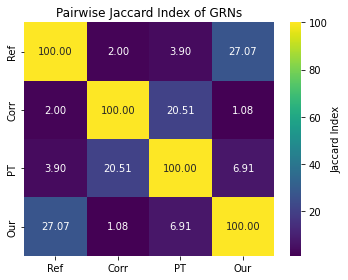

In [21]:
# Load the three GRNs with the true GRN to compare them:
corr_grn = load_edge_set('Data/PBMC/Corr_edges.csv')
pt_grn = load_edge_set('Data/PBMC/PT_edges.csv')
our_grn = load_edge_set('Data/PBMC/GnnPT_edges.csv')

# List of all GRNs
grns = [ref_grn, corr_grn, pt_grn, our_grn]

# Create a DataFrame to store the results
jaccard_results = pd.DataFrame(index=['Ref', 'Corr', 'PT', 'Our'], columns=['Ref', 'Corr', 'PT', 'Our'])
# Fill the DataFrame with Jaccard indices
for i, grn1 in enumerate(grns):
    for j, grn2 in enumerate(grns):
        jaccard_results.iloc[i, j] = np.round(100*jaccard_index(grn1, grn2),2)

print("Jaccard Index Results:")
print(jaccard_results)

# plot the Jaccard Index results as a heatmap
plt.figure(figsize=(5, 4), facecolor='white')
sns.heatmap(jaccard_results.astype(float), annot=True, cmap='viridis', fmt=".2f", cbar_kws={'label': 'Jaccard Index'})
plt.title('Pairwise Jaccard Index of GRNs')
# plt.xlabel('GRN 1')
# plt.ylabel('GRN 2')
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Plots/PBMC.jpg', dpi=300)
plt.show()


In [22]:
# Get the set of all genes in the reference GRN
all_genes = set()
for u, v in ref_grn:
    all_genes.add(u)
    all_genes.add(v)

# Compute confusion matrices
cm_corr, f1_corr, recall_corr, pre_corr = compute_confusion_matrix(corr_grn, ref_grn, all_genes)
cm_pt, f1_pt, recall_pt, pre_pt = compute_confusion_matrix(pt_grn, ref_grn, all_genes)
cm_celloracle, f1_cell, recall_cell, pre_cell = compute_confusion_matrix(cell_grn, ref_grn, all_genes)
cm_our, f1_our, recall_our, pre_our = compute_confusion_matrix(our_grn, ref_grn, all_genes)


# display the confusion matrices for the two networks
print("Confusion Matrix for Correlation Network:")
print(cm_corr, " Recall:", recall_corr, " Precision:", pre_corr, "F1 Score:", f1_corr)

print("Confusion Matrix for PT Network:")
print(cm_pt, " Recall: ", recall_pt, " Precision:", pre_pt, "F1 Score:", f1_pt)

print("Confusion Matrix for CellOracle Network:")
print(cm_celloracle, " Recall: ", recall_cell, " Precision:", pre_cell, "F1 Score:", f1_cell)

print("Confusion Matrix for GNN Network:")
print(cm_our, " Recall:", recall_our, " Precision:", pre_our, "F1 Score:", f1_our)



Confusion Matrix for Correlation Network:
[[237040  73076]
 [  9400   1685]]  Recall: 15.2  Precision: 2.25 F1 Score: 3.93
Confusion Matrix for PT Network:
[[161880 148236]
 [  4878   6207]]  Recall:  55.99  Precision: 4.02 F1 Score: 7.5
Confusion Matrix for CellOracle Network:
[[305860   4272]
 [  8842   2243]]  Recall:  20.23  Precision: 34.43 F1 Score: 25.49
Confusion Matrix for GNN Network:
[[296423  13693]
 [  4378   6707]]  Recall: 60.51  Precision: 32.88 F1 Score: 42.6
